# Valence ML/AI/DS Challenge Part 1: Preprocess + EDA + Convo Sampling

In [2]:
import pandas as pd
pd.set_option('display.width', 10000)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


#### Part 1: Data Preparation: Load

In [104]:
#Basic line-by-line read in of .txt, /t separated
# file_path = "MWOZ.txt"

# with open(file_path, "r") as file:
#     for line in file:
#         print(line.strip())


In [3]:
import pandas as pd

# Step 1: Load the MWOZ data
file_path = "../data/raw/MWOZ.txt"  # Replace with your file path
mwoz = pd.read_csv(file_path, sep="\t", header=None, names=[
    "Speaker", "Text", "Domain-Intent", "Rating 1", "Rating 2", "Rating 3", "Rating 4", "Rating 5"
])

# Step 2: Parse ratings into columns
ratings_split = mwoz["Rating 1"].str.split(",", expand=True)
mwoz["Rating 1"] = ratings_split[0]
mwoz["Rating 2"] = ratings_split[1]
mwoz["Rating 3"] = ratings_split[2]
mwoz["Rating 4"] = ratings_split[3]
mwoz["Rating 5"] = ratings_split[4]
mwoz.replace(to_replace=[None], value=np.nan, inplace=True)

#Splice domain vs Intent
mwoz['Domain'] = mwoz['Domain-Intent'].str.split("-").str[0]
mwoz['Intent'] = mwoz['Domain-Intent'].str.split("-").str[1]

# Step 3: Identify breaks in conversations and create break lines
break_indices = (mwoz["Speaker"] == "USER") & (mwoz["Text"] == "OVERALL")
break_rows = pd.DataFrame({"Speaker": ["BREAK"] * break_indices.sum(),
                           "Text": ["--- End of Conversation ---"] * break_indices.sum(),
                           "Domain-Intent": [None] * break_indices.sum(),
                           "Rating 1": [None] * break_indices.sum(),
                           "Rating 2": [None] * break_indices.sum(),
                           "Rating 3": [None] * break_indices.sum(),
                           "Rating 4": [None] * break_indices.sum(),
                           "Rating 5": [None] * break_indices.sum()})
# Add average rating col
rating_columns = ['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5']
mwoz[rating_columns] = mwoz[rating_columns].apply(pd.to_numeric, errors='coerce')
mwoz['avg_rating'] = mwoz[rating_columns].mean(axis=1).round(2)

# Add a marker column for sorting
mwoz["IsBreak"] = break_indices
# Concat original data with break rows
mwoz = pd.concat([mwoz, break_rows], ignore_index=True).sort_index(kind="merge")

# Remove marker column and reset index
mwoz = mwoz.drop(columns=["IsBreak"]).reset_index(drop=True)
# Enumerate convos, convo ID for sampling
mwoz['ConvID'] = ((mwoz['Speaker'] == 'USER') & (mwoz['Text'] == 'OVERALL')).cumsum()

# Assign "OVERALL" rows to the previous convo ID
mwoz['ConvID'] = mwoz['ConvID'].where(
    ~((mwoz['Speaker'] == 'USER') & (mwoz['Text'] == 'OVERALL')), 
    mwoz['ConvID'] - 1
)

mwoz = mwoz[mwoz['ConvID'] != 1000]
#Per ConvID, set turn id for each line
mwoz['turn_id'] = mwoz.groupby('ConvID').cumcount()
# mwoz.set_index("ConvID", inplace=True)
mwoz.reset_index(inplace=True)
mwoz.to_csv("../data/output/mwoz_0processed.csv", index=False)
mwoz.iloc[30:50]

,index,Speaker,Text,Domain-Intent,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Domain,Intent,avg_rating,ConvID,turn_id
30,30,USER,I would also like to book a taxi from the Arch...,Taxi-Inform,3.0,3.0,3.0,NaN,NaN,Taxi,Inform,3.00,1,16
31,31,SYSTEM,Certainly. What is your destination?,Taxi-Request,NaN,NaN,NaN,NaN,NaN,Taxi,Request,NaN,1,17
32,32,USER,Could you recommend a nightclub from the previ...,NaN,3.0,3.0,3.0,NaN,NaN,NaN,NaN,3.00,1,18
33,33,SYSTEM,"Yeah, the ballare is great. It's in the centre...",Attraction-Recommend,NaN,NaN,NaN,NaN,NaN,Attraction,Recommend,NaN,1,19
34,34,USER,"No, I did mean 09:45, thank you.",general-thank,2.0,2.0,3.0,NaN,NaN,general,thank,2.33,1,20
35,35,SYSTEM,"Okay great, the car will be a black honda and ...",Taxi-Inform,NaN,NaN,NaN,NaN,NaN,Taxi,Inform,NaN,1,21
36,36,USER,Will it be possible to cancel my taxi booking ...,NaN,3.0,3.0,3.0,NaN,NaN,NaN,NaN,3.00,1,22
37,37,SYSTEM,"Sure, you can cancel your taxi reservation wit...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,23
38,38,USER,My plan is not confirmed yet. So I may need to...,NaN,3.0,3.0,3.0,NaN,NaN,NaN,NaN,3.00,1,24
39,39,SYSTEM,You can cancel 24 hours in advance. After that...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,25


##### 1A Data Quality Check

In [106]:
#Checking Missingness
print(mwoz.isnull().sum()/mwoz.shape[0]*100)


index             0.000000
Speaker           0.000000
Text              0.000000
Domain-Intent    34.741215
Rating 1         45.676822
Rating 2         45.676822
Rating 3         45.676822
Rating 4         76.423749
Rating 5         96.927471
Domain           34.741215
Intent           34.741215
avg_rating       45.676822
ConvID            0.000000
turn_id           0.000000
dtype: float64


In [39]:
mwoz[(mwoz['Speaker']=='SYSTEM') &(mwoz['wt_avg_rating'].notna())]

,index,Speaker,Text,Domain-Intent,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Domain,Intent,avg_rating,ConvID,turn_id,WordCount,wt_avg_rating,word_count


In [107]:
# Check User vs. System Balance:
print(mwoz.groupby('Speaker')['Text'].count()/mwoz.shape[0]*100)

Speaker
SYSTEM    45.676822
USER      54.323178
Name: Text, dtype: float64


##### 1B Structure and Annotation Consistency

In [108]:
#Check Intent-Text Alignment, by Turn
#1. Keyword Analysis
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# nltk.download('stopwords')

# Define stop words and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# FUNCTION to preprocess text by removing stopwords and punctuation
def preprocess_text(text):
    tokens = text.lower().split()  # Tokenize and lowercase
    return [word for word in tokens if word not in stop_words and word not in punctuation]

# Perform keyword analysis for each intent
intent_keywords = {}
for intent, group in mwoz.groupby('Intent'):
    all_text = " ".join(group['Text'].dropna())  # Combine all text for the intent
    filtered_words = preprocess_text(all_text)  # Remove stopwords and punctuation
    intent_keywords[intent] = Counter(filtered_words).most_common(10)  # Get top 5 keywords

intent_keywords_df=pd.DataFrame(intent_keywords).T
intent_keywords_df

,0,1,2,3,4,5,6,7,8,9
Book,"(reference, 616)","(number, 605)","(anything, 331)","(booking, 235)","(else, 218)","(help, 216)","(table, 165)","(booked, 156)","(successful., 155)","(else?, 126)"
Inform,"(like, 1284)","(would, 1276)","(need, 1253)","(book, 995)","(looking, 808)","(hotel, 703)","(restaurant, 695)","(free, 683)","(i'm, 643)","(also, 597)"
NoBook,"(book, 24)","(i'm, 23)","(booking, 22)","(like, 21)","(would, 18)","(try, 16)","(sorry,, 16)","(unable, 12)","(sorry, 12)","(you., 11)"
NoOffer,"(i'm, 126)","(sorry,, 84)","(would, 79)","(sorry, 72)","(like, 63)","(hotels, 49)","(restaurants, 48)","(another, 42)","(find, 39)","(try, 37)"
OfferBook,"(book, 198)","(would, 189)","(like, 170)","(train, 112)","(you?, 90)","(arrives, 78)","(leaves, 68)","(cambridge, 55)","(leaving, 36)","(one, 23)"
OfferBooked,"(reference, 187)","(number, 182)","(total, 106)","(fee, 98)","(gbp, 97)","(payable, 97)","(anything, 93)","(booking, 80)","(booked, 61)","(else, 60)"
Recommend,"(would, 111)","(recommend, 70)","(like, 66)","(restaurant, 45)","(located, 43)","(suggest, 38)","(city, 34)","(book, 31)","(centre, 29)","(centre., 27)"
Request,"(would, 904)","(like, 789)","(need, 489)","(time, 397)","(price, 385)","(area, 327)","(number, 316)","(day, 290)","(phone, 283)","(many, 280)"
Select,"(would, 117)","(one, 69)","(like, 55)","(two, 52)","(prefer, 36)","(cheap, 34)","(preference?, 31)","(hotel, 30)","(2, 29)","(prefer?, 28)"
bye,"(thank, 93)","(bye., 61)","(good, 42)","(goodbye., 31)","(thanks, 29)","(you,, 28)","(day., 25)","(bye!, 22)","(great, 20)","(no,, 20)"


In [18]:
#Check Intent-Text Alignment, by Turn
#TODO 2. Similarity-Based Validation

import spacy
import pandas as pd

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Ensure both 'Text' and 'Intent' are strings, replacing NaN or non-string values with an empty string
mwoz['Text'] = mwoz['Text'].fillna('').astype(str)
mwoz['Intent'] = mwoz['Intent'].fillna('').astype(str)

# Calculate text-intent similarity
mwoz['IntentSimilarity'] = mwoz.apply(
    lambda row: nlp(row['Text']).similarity(nlp(row['Intent'])), 
    axis=1
)

# Flag low similarity pairs
low_similarity = mwoz[mwoz['IntentSimilarity'] < 0.5]
print(low_similarity[['Intent', 'Text', 'IntentSimilarity']])


/var/folders/86/342cc_xx61zdhxc_bdjg3l540000gn/T/ipykernel_38401/3174185380.py:16: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  lambda row: nlp(row['Text']).similarity(nlp(row['Intent'])),
/var/folders/86/342cc_xx61zdhxc_bdjg3l540000gn/T/ipykernel_38401/3174185380.py:16: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  lambda row: nlp(row['Text']).similarity(nlp(row['Intent'])),


        Intent                                               Text  IntentSimilarity
0       Inform  I'm looking for a cheap restaurant in the east...          0.084357
1       Inform  the missing sock is a nice restaurant in the e...          0.055351
2      Request              What is the address and phone number?          0.254721
3      reqmore  The address of The Missing Sock is Finders Cor...          0.337966
4                Does this restaurant have highchairs for babies?          0.000000
...        ...                                                ...               ...
23103           Room service is not available at the Acorn Hou...          0.000000
23104   Inform  I would like one that is in the expensive pric...          0.145368
23105  Request  I am sorry but I cannot find a guesthouse in t...          0.092026
23106   Inform  No, are there any guesthouses available in the...          0.122898
23107                                                     OVERALL          0

In [19]:
#Check Intent-Text Alignment, by Turn
#Check for outliers in text length by intent
mwoz['TextLength'] = mwoz['Text'].str.len()
outliers = mwoz.groupby('Intent').apply(lambda x: x[(x['TextLength'] < x['TextLength'].quantile(0.05)) | 
                                                     (x['TextLength'] > x['TextLength'].quantile(0.95))])
print(outliers)

# outliers.to_csv("mwoz_intent_text_length_outliers.csv", index=False)



               index Speaker                                               Text    Domain-Intent  Rating 1  Rating 2  Rating 3  Rating 4  Rating 5   Domain   Intent  avg_rating  ConvID  turn_id  IntentSimilarity  TextLength
Intent                                                                                                                                                                                                                         
        5          5  SYSTEM  I'm afraid there is no high chair seating avai...              NaN       NaN       NaN       NaN       NaN       NaN      NaN                  NaN       0        5          0.000000         133
        37        37  SYSTEM  Sure, you can cancel your taxi reservation wit...              NaN       NaN       NaN       NaN       NaN       NaN      NaN                  NaN       1       23          0.000000         165
        247      247  SYSTEM  I'm sorry, it doesn't look like they have Hala...              NaN       N

/var/folders/86/342cc_xx61zdhxc_bdjg3l540000gn/T/ipykernel_38401/387784882.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = mwoz.groupby('Intent').apply(lambda x: x[(x['TextLength'] < x['TextLength'].quantile(0.05)) |


In [7]:
NOT_OVERALL = mwoz[mwoz['Text'] != 'OVERALL']
OVERALL = mwoz[mwoz['Text'] == 'OVERALL']

USER = mwoz[mwoz['Speaker'] == 'USER']
SYSTEM = mwoz[mwoz['Speaker'] == 'SYSTEM']

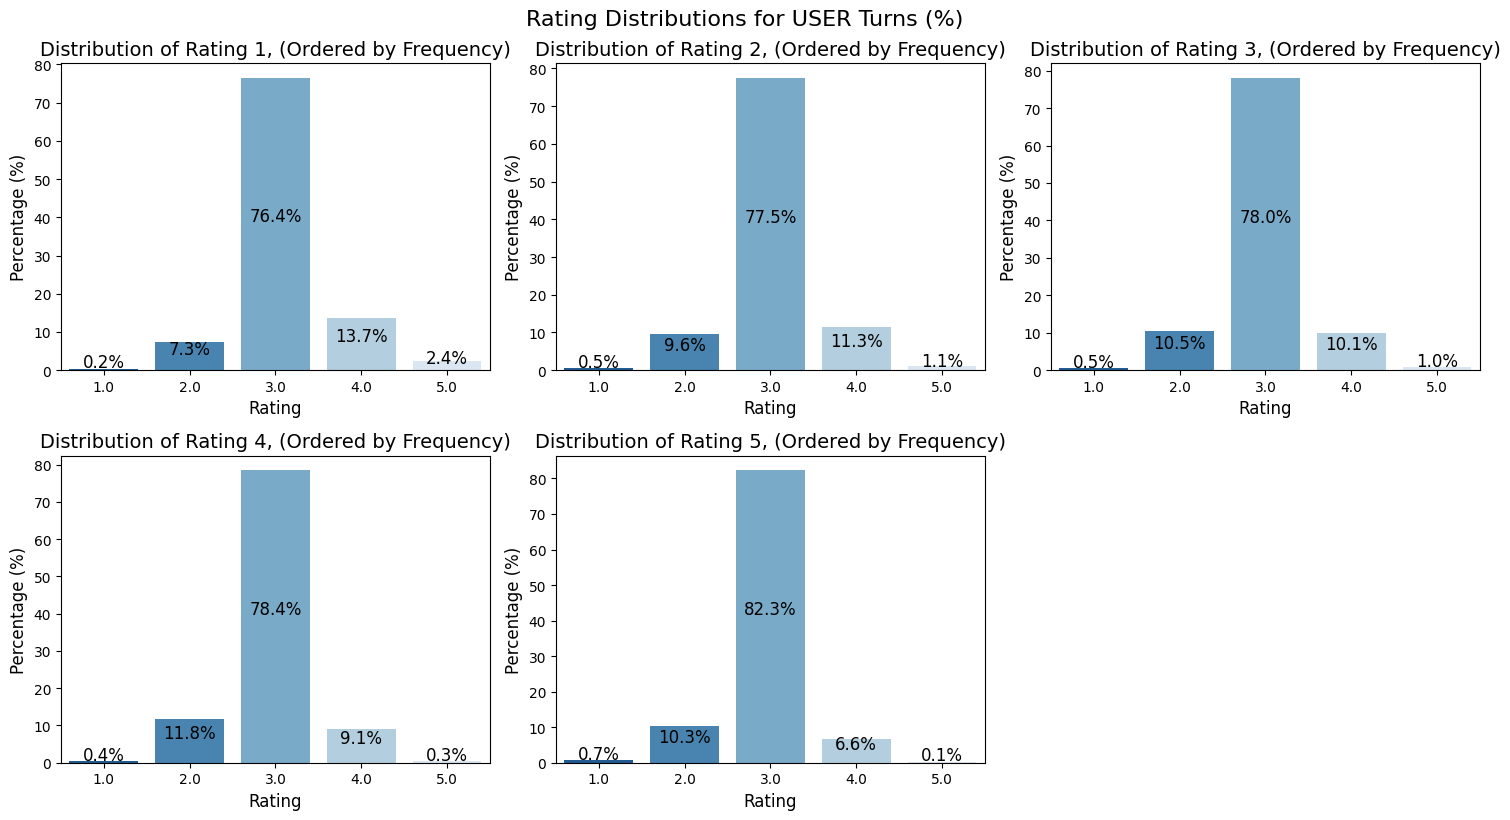

Takeaway: Rating 4 & 5 are highly missing, Rating 1, 2, 3 have ~50% missing and are most popularly 3.


In [8]:
#VIZ: Check Rating Distribution
# # Replace NaN values with "NA" for the rating columns
for column in rating_columns:
    mwoz[column] = mwoz[column].fillna("NA")

# Set up the figure and subplots
plt.figure(figsize=(15, 8))

NOTOVERALL = mwoz[mwoz['Text'] != 'OVERALL']

for i, column in enumerate(rating_columns, start=1):
    plt.subplot(2, 3, i)  # Create a 2x3 grid of subplots

    # Calculate column-wise frequency counts and normalize
    total_count = USER[column].notna().sum()  # Total non-missing values in the column
    rating_counts = USER[column].value_counts().sort_index() / total_count * 100  # Convert to percentages

    bars = sns.barplot(
        x=rating_counts.index, 
        y=rating_counts.values, 
        palette="Blues_r"
    )
    
    plt.title(f"Distribution of {column}, (Ordered by Frequency)", fontsize=14)
    plt.xlabel("Rating", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)

    # Add annotations for percentages
    for bar, percentage in zip(bars.patches, rating_counts.values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # Centered horizontally
            bar.get_height() / 2+2,  # Slightly above the bar
            f'{percentage:.1f}%',  # Display percentage with 1 decimal
            ha='center', 
            va='center',
            fontsize=12,
            color='black'
        )

# Adjust layout
plt.tight_layout()
plt.suptitle("Rating Distributions for USER Turns (%)", fontsize=16, y=1.02)  # Add a global title
plt.show()

print("Takeaway: Rating 4 & 5 are highly missing, Rating 1, 2, 3 have ~50% missing and are most popularly 3.")


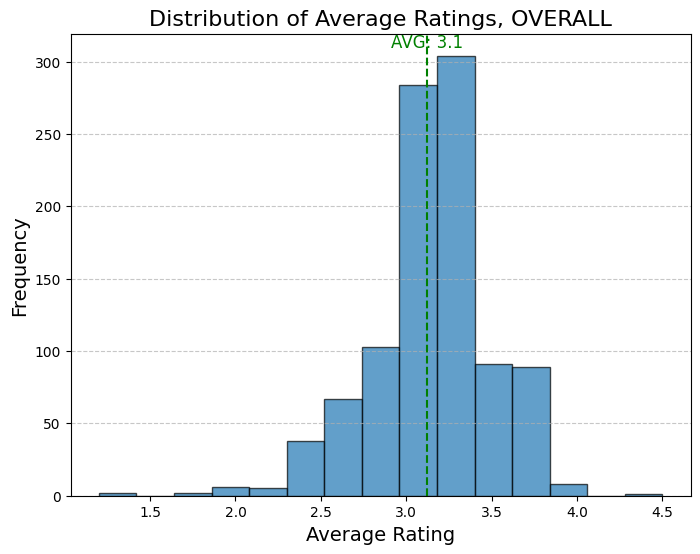

Takeaway: Given we know Rating 4 & 5 are highly missing, to aggregate across scores, let's take the weighted average (prior plain average). 


In [9]:
#VIZ: Check avg rating distribution
import matplotlib.pyplot as plt

valid_ratings = OVERALL['avg_rating'].dropna()
mean_length = valid_ratings.mean()

plt.figure(figsize=(8, 6))
plt.hist(valid_ratings, bins=15, edgecolor='black', alpha=0.7)
plt.title('Distribution of Average Ratings, OVERALL', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add a vertical line for the mean, w annotation
plt.axvline(mean_length, color='green', linestyle='--', label=f"Mean @ {mean_length:.1f}")  
plt.text(
    mean_length, 
    plt.ylim()[1] * 0.97,  # Position the label near the top
    f"AVG: {mean_length:.1f}", 
    color="green", 
    fontsize=12, 
    ha="center"
)

plt.show()
print("Takeaway: Given we know Rating 4 & 5 are highly missing, to aggregate across scores, let's take the weighted average (prior plain average). ")



In [10]:
#Change score aggregation from average to weighted avg based on coverage

rating_columns = ["Rating 1", "Rating 2", "Rating 3", "Rating 4", "Rating 5"]
# Ensure all columns are numeric
mwoz[rating_columns] = mwoz[rating_columns].apply(pd.to_numeric, errors='coerce')

# Function to calculate the weighted average
def weighted_average(row, weights):
    # Multiply by weights and sum, ignoring NaN
    weighted_sum = np.nansum(row * weights)
    sum_weights = np.nansum([w if not np.isnan(val) else 0 for val, w in zip(row, weights)])
    return weighted_sum / sum_weights if sum_weights > 0 else np.nan

# Calculate coverage-based weights
coverage = mwoz[rating_columns].notna().mean()
weights = coverage / coverage.sum()

mwoz["wt_avg_rating"] = mwoz[rating_columns].apply(lambda row: weighted_average(row, weights), axis=1).round(3)

print(mwoz.head())





   index Speaker                                                                                                                                             Text       Domain-Intent  Rating 1  Rating 2  Rating 3  Rating 4  Rating 5      Domain   Intent  avg_rating  ConvID  turn_id  wt_avg_rating
0      0    USER                                                                                     I'm looking for a cheap restaurant in the east part of town.   Restaurant-Inform       3.0       3.0       3.0       3.0       NaN  Restaurant   Inform         3.0       0        0            3.0
1      1  SYSTEM                                                          the missing sock is a nice restaurant in the east part of town in the cheap price range   Restaurant-Inform       NaN       NaN       NaN       NaN       NaN  Restaurant   Inform         NaN       0        1            NaN
2      2    USER                                                                                             

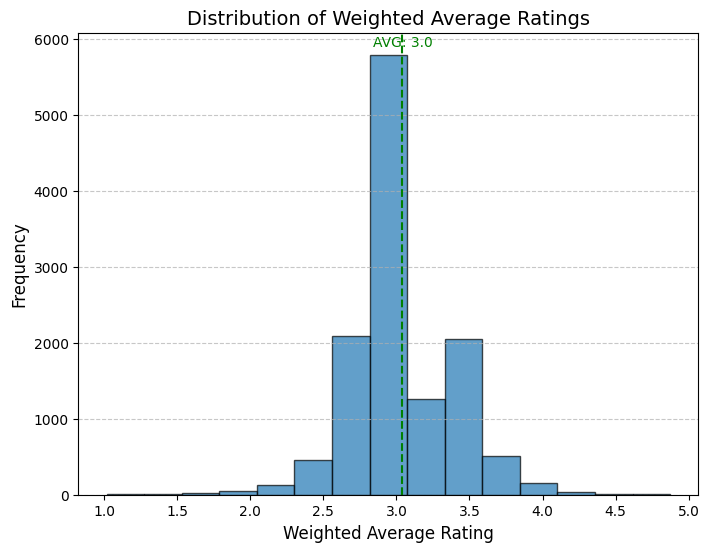

In [11]:
#VIZ: Check weighted avg rating distribution
valid_ratings = mwoz['wt_avg_rating'].dropna()
mean_length = valid_ratings.mean()

plt.figure(figsize=(8, 6))
plt.hist(valid_ratings, bins=15, edgecolor='black', alpha=0.7)
plt.title('Distribution of Weighted Average Ratings', fontsize=14)
plt.xlabel('Weighted Average Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add a vertical line for the mean, w annotation
plt.axvline(mean_length, color='green', linestyle='--', label=f"Mean @ {mean_length:.1f}")  
plt.text(
    mean_length, 
    plt.ylim()[1] * 0.97,  # Position the label near the top
    f"AVG: {mean_length:.1f}", 
    color="green", 
    fontsize=10, 
    ha="center"
)

plt.show()



In [12]:
# Calculate Quartiles
quartiles = mwoz["wt_avg_rating"].quantile([0.25, 0.5, 0.75])
print("Quartiles:")
print(quartiles)

# Calculate Deciles
deciles = mwoz["wt_avg_rating"].quantile([i / 10 for i in range(1, 10)])
print("\nDeciles:")
print(deciles)

Quartiles:
0.25    3.000
0.50    3.000
0.75    3.291
Name: wt_avg_rating, dtype: float64

Deciles:
0.1    2.667
0.2    2.709
0.3    3.000
0.4    3.000
0.5    3.000
0.6    3.000
0.7    3.286
0.8    3.333
0.9    3.573
Name: wt_avg_rating, dtype: float64


In [13]:
# Define the thresholds based on the deciles
low_threshold = 2.71  # 0.2 decile
high_threshold = 3.29  # 0.7 decile

# Categorize scores into 'Low', 'Medium', and 'High'
def categorize_satisfaction(score):
    if score <= low_threshold:
        return "Low"
    elif score > high_threshold:
        return "High"
    else:
        return "Medium"

# Create the new column 'satisfaction_rating'
mwoz["satisfaction_rating"] = mwoz["wt_avg_rating"].apply(categorize_satisfaction)

print(mwoz["satisfaction_rating"].value_counts())


satisfaction_rating
Medium    16738
High       3698
Low        2672
Name: count, dtype: int64


##### 1C Intent Coverage, Domain Balance, Convo Length, User Balance


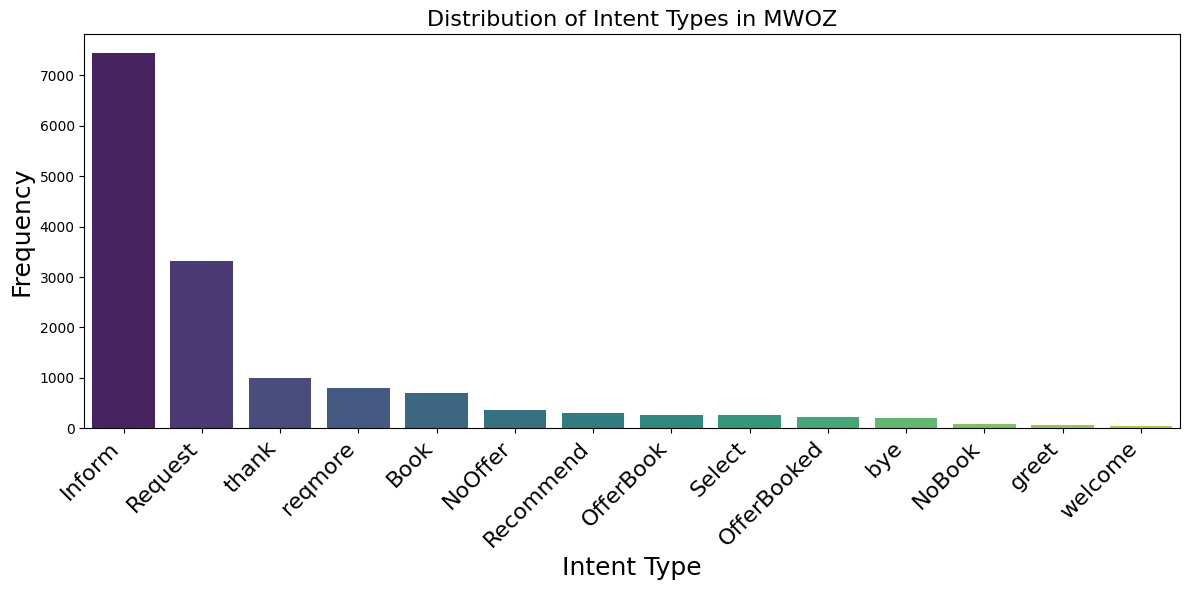

In [14]:
#VIZ Intent only, domain agnostic
# Extract the second part of the intent after the dash
mwoz['Intent Type'] = mwoz['Intent'].str.split("-").str[-1]

# Count occurrences of each intent type
intent_type_counts = mwoz['Intent Type'].value_counts().reset_index()
intent_type_counts.columns = ['Intent Type', 'Count']

# Generate a bar plot for intent types
plt.figure(figsize=(12, 6))
sns.barplot(data=intent_type_counts, x='Intent Type', y='Count', hue = 'Intent Type',palette="viridis")
plt.title("Distribution of Intent Types in MWOZ", fontsize=16)
plt.xlabel("Intent Type", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(rotation=45, ha="right", fontsize=16)
plt.tight_layout()
plt.show();



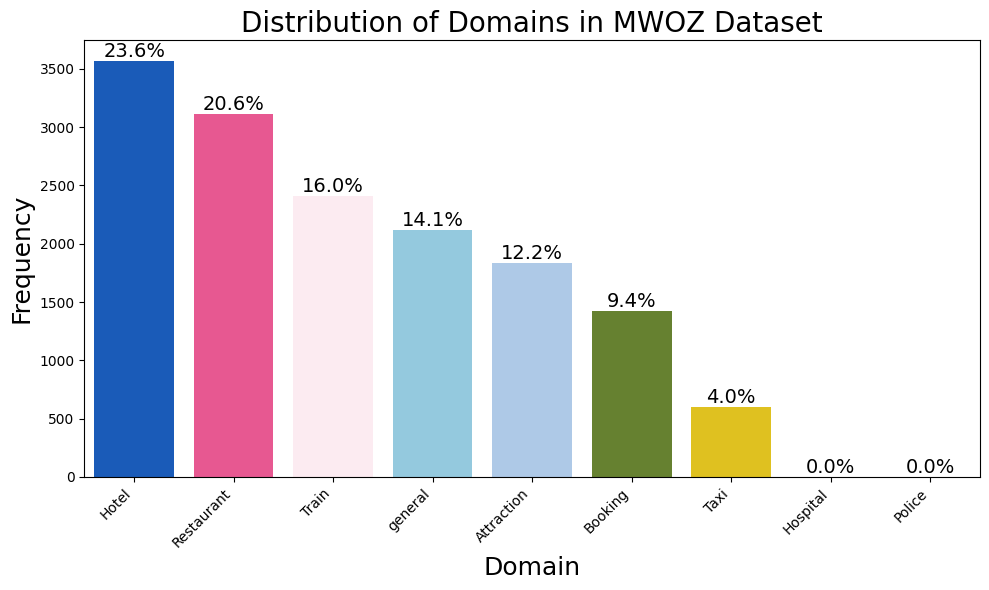

In [15]:
#VIZ Count occurrences of each domain

# Assign colors to domains
domain_colors = {
    "Hotel": "#0056D2",  # Blue
    "Restaurant": "#FF408C",  # Pink
    "Attraction": "#A4C8F0",  # Light Blue
    "General": "#FF99C8",  # Light Pink
    "Train": "#FFE8F0",  # Soft Pink
    "Taxi": "#FFD700",  # Yellow
    "Booking": "#6B8E23",  # Green
    "Police": "#D4A5FF",
    "general": "#87CEEB", #sky blue
    "Hospital": "#FF8674", #coral
    "Other": "#CCCCCC"   # Gray for undefined intents
}

# Count occurrences of each domain
domain_counts = mwoz['Domain'].value_counts().reset_index()
domain_counts.columns = ['Domain', 'Count']

# Calculate % per domain
total_count = domain_counts['Count'].sum()
domain_counts['Percentage'] = (domain_counts['Count'] / total_count) * 100  # Add Percentage column

# Plot, with domain colors
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=domain_counts, x='Domain', y='Count', palette=domain_colors)
plt.title("Distribution of Domains in MWOZ Dataset", fontsize=20)
plt.xlabel("Domain", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(rotation=45, ha="right")

# Add percentage annotations above each bar
for p, percentage in zip(barplot.patches, domain_counts['Percentage']):
    plt.text(
        x=p.get_x() + p.get_width() / 2,  # Center text on the bar
        y=p.get_height(),  # Position at the top of the bar
        s=f"{percentage:.1f}%",  # Format as a percentage
        ha="center", 
        va="bottom", 
        fontsize=14
    )

plt.tight_layout()
plt.show()


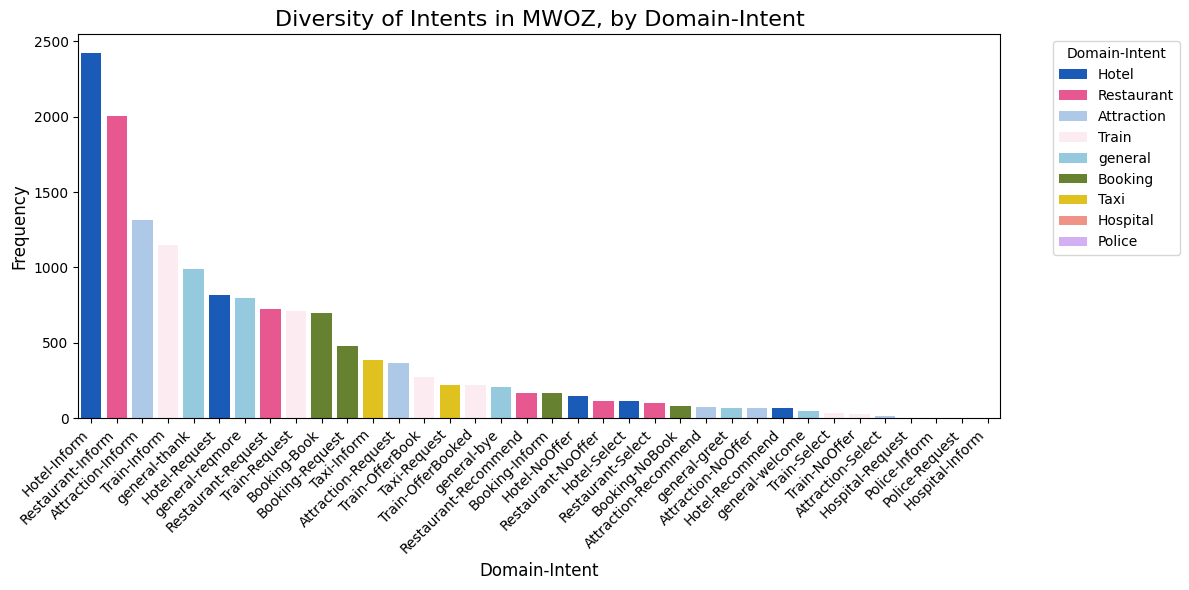

In [16]:
#VIZ Check Diversity of Intents x Domains

# Count the occurrences of each intent
intent_counts = mwoz['Domain-Intent'].value_counts().reset_index()
intent_counts.columns = ['Domain-Intent', 'Count']

# Ensure unique intents for mapping domains
unique_intents = mwoz[['Domain-Intent', 'Domain']].drop_duplicates()
intent_counts = intent_counts.merge(unique_intents, on='Domain-Intent', how='left')

# plot
plt.figure(figsize=(12, 6))
sns.barplot(data=intent_counts, x='Domain-Intent', y='Count', hue='Domain', dodge=False, palette=domain_colors)
plt.title("Diversity of Intents in MWOZ, by Domain-Intent", fontsize=16)
plt.xlabel("Domain-Intent", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, ha="right")

    
plt.legend(title="Domain-Intent", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [17]:
# Count the occurrences of each intent
intent_counts = mwoz['Intent'].value_counts(normalize=True).reset_index()
intent_counts.columns = ['Intent', 'Frequency']
intent_counts['Frequency'] *= 100  # Convert to percentage

# Ensure unique intents for mapping domains
unique_intents = mwoz[['Intent', 'Domain']].drop_duplicates()
intent_counts = intent_counts.merge(unique_intents, on='Intent', how='left')

intent_counts
# Plot
# plt.figure(figsize=(20, 6))
# barplot = sns.barplot(data=intent_counts, x='Domain', y='Frequency', hue='Intent', dodge=True, palette="viridis")
# plt.title("Grouped Diversity of Intents in MWOZ, by Domain", fontsize=16)
# plt.xlabel("Domain", fontsize=12)
# plt.ylabel("Frequency (%)", fontsize=12)
# plt.xticks(rotation=45, ha="right")
# plt.legend(title="Intent", bbox_to_anchor=(1.05, 1), loc='upper left')

# # Add annotations to each bar
# for p in barplot.patches:
#     percentage = f"{p.get_height():.1f}%"  # Format as percentage
#     plt.text(
#         x=p.get_x() + p.get_width() / 2,  # Center text on bar
#         y=p.get_height(),  # Position at the top of the bar
#         s=percentage, 
#         ha='center', 
#         va='bottom', 
#         fontsize=10
#     )

# plt.tight_layout()
# plt.show()


,Intent,Frequency,Domain
0,Inform,49.363395,Restaurant
1,Inform,49.363395,Attraction
2,Inform,49.363395,Hotel
3,Inform,49.363395,Booking
4,Inform,49.363395,Taxi
5,Inform,49.363395,Train
6,Inform,49.363395,Hospital
7,Inform,49.363395,Police
8,Request,22.015915,Restaurant
9,Request,22.015915,Attraction


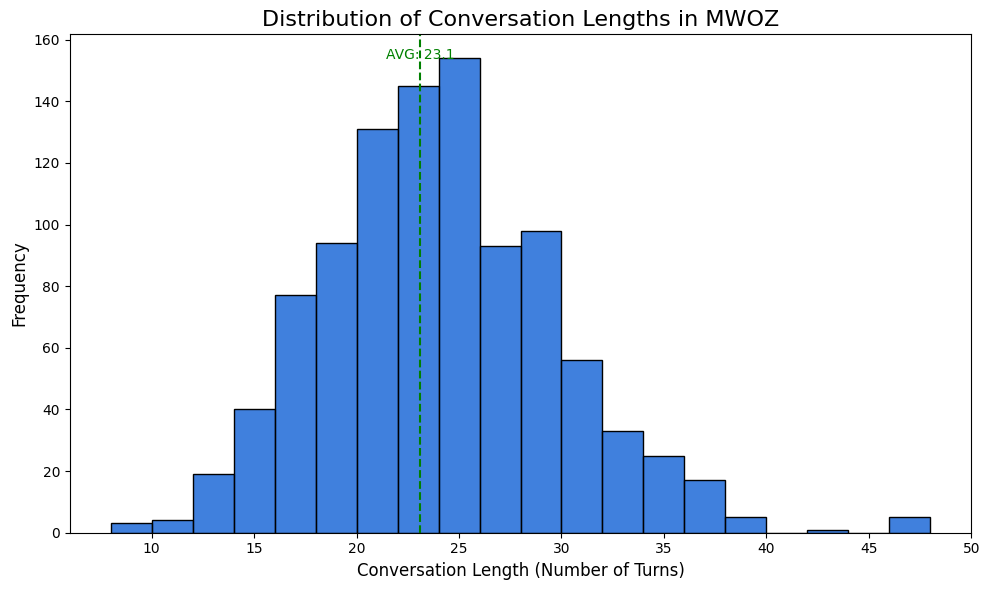

In [18]:
#VIZ convo length
conversation_lengths = mwoz.groupby('ConvID').size()
mean_length = conversation_lengths.mean()

# Plot the distribution of conversation lengths
plt.figure(figsize=(10, 6))
sns.histplot(conversation_lengths, bins=20, kde=False, color="#0056D2") 
# Add a vertical line for the mean, w annotation
plt.axvline(mean_length, color='green', linestyle='--', label=f"Mean @ {mean_length:.1f}")  
plt.text(
    mean_length, 
    plt.ylim()[1] * 0.95,  # Position the label near the top
    f"AVG: {mean_length:.1f}", 
    color="green", 
    fontsize=10, 
    ha="center"
)
plt.title("Distribution of Conversation Lengths in MWOZ", fontsize=16)
plt.xlabel("Conversation Length (Number of Turns)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



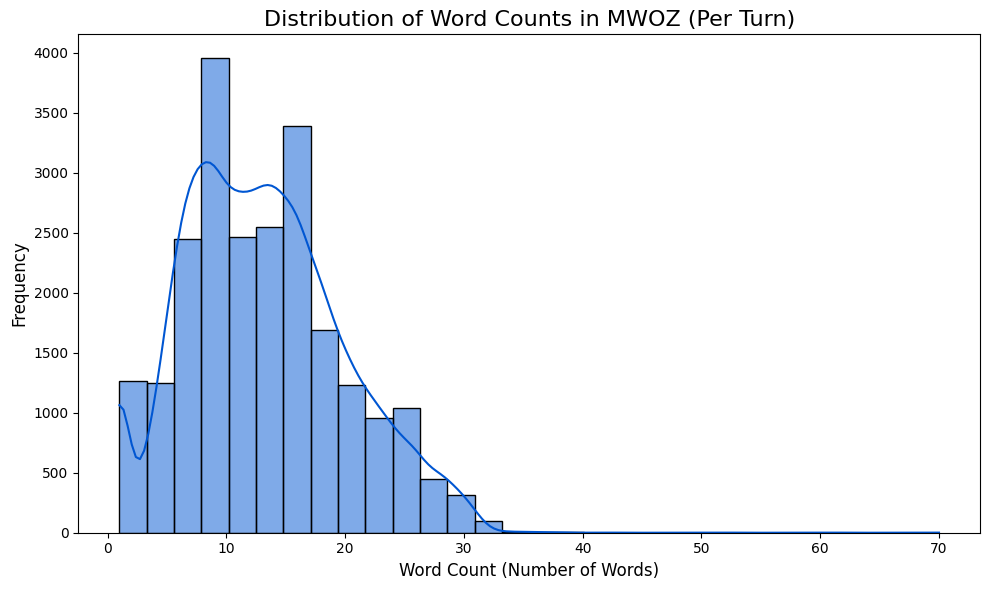

In [19]:
#VIZ turn length, # of words

# Calculate the word count for each turn in the "Text" column
mwoz['word_count'] = mwoz['Text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Plot the distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(mwoz['word_count'].dropna(), bins=30, kde=True, color="#0056D2")  # Soft blue color
plt.title("Distribution of Word Counts in MWOZ (Per Turn)", fontsize=16)
plt.xlabel("Word Count (Number of Words)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [23]:
#INVESTIGATE: texts with outlying long length
# Filter the dataset for rows where the "WordCount" is over 50
pd.set_option('display.max_colwidth', None)
# filtered_mwoz = mwoz[mwoz['WordCount'] >50]
filtered_mwoz = mwoz[
    (mwoz['word_count'] < 5) & 
    (~mwoz['Text'].str.contains('OVERALL|Goodbye|bye|thank', case=False, na=False))
]

filtered_mwoz.to_csv("../data/output/analysis/outlying_length_turns.csv")
# filtered_mwoz['Speaker'].value_counts()

print("Takeaway: Right tail outlier texts with >50 words are from the System. Left tail outlier texts with <5 words, not containing overall, goodbye, thank, are mostly from the user.")
filtered_mwoz



Takeaway: Right tail outlier texts with >50 words are from the System. Left tail outlier texts with <5 words, not containing overall, goodbye, thank, are mostly from the user.


,index,Speaker,Text,Domain-Intent,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Domain,Intent,avg_rating,ConvID,turn_id,wt_avg_rating,satisfaction_rating,Intent Type,word_count
246,246,USER,Any Halal options?,NaN,3.0,2.0,3.0,3.0,NaN,NaN,NaN,2.75,10,10,2.709,Low,NaN,3
307,307,SYSTEM,What's your price range?,Restaurant-Request,NaN,NaN,NaN,NaN,NaN,Restaurant,Request,NaN,13,5,NaN,Medium,Request,4
345,345,SYSTEM,How about curry prince?,Restaurant-Recommend,NaN,NaN,NaN,NaN,NaN,Restaurant,Recommend,NaN,14,15,NaN,Medium,Recommend,4
348,348,USER,Friday at 18:30 please,NaN,3.0,3.0,3.0,NaN,NaN,NaN,NaN,3.00,14,18,3.000,Medium,NaN,4
385,385,SYSTEM,154 chesterton road,Hotel-Inform,NaN,NaN,NaN,NaN,NaN,Hotel,Inform,NaN,15,25,NaN,Medium,Inform,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22955,22955,SYSTEM,For how many people?,Train-Request,NaN,NaN,NaN,NaN,NaN,Train,Request,NaN,993,15,NaN,Medium,Request,4
22980,22980,USER,I don't care.,NaN,3.0,3.0,3.0,NaN,NaN,NaN,NaN,3.00,994,4,3.000,Medium,NaN,3
22982,22982,USER,I don't care,NaN,2.0,3.0,2.0,NaN,NaN,NaN,NaN,2.33,994,6,2.333,Low,NaN,3
22992,22992,USER,What is the postcode?,NaN,3.0,3.0,3.0,NaN,NaN,NaN,NaN,3.00,994,16,3.000,Medium,NaN,4


In [28]:
NOT_OVERALL = mwoz[mwoz['Text'] != 'OVERALL']
OVERALL = mwoz[mwoz['Text'] == 'OVERALL']

USER = mwoz[mwoz['Speaker'] == 'USER']
SYSTEM = mwoz[mwoz['Speaker'] == 'SYSTEM']

(0.0, 40.0)

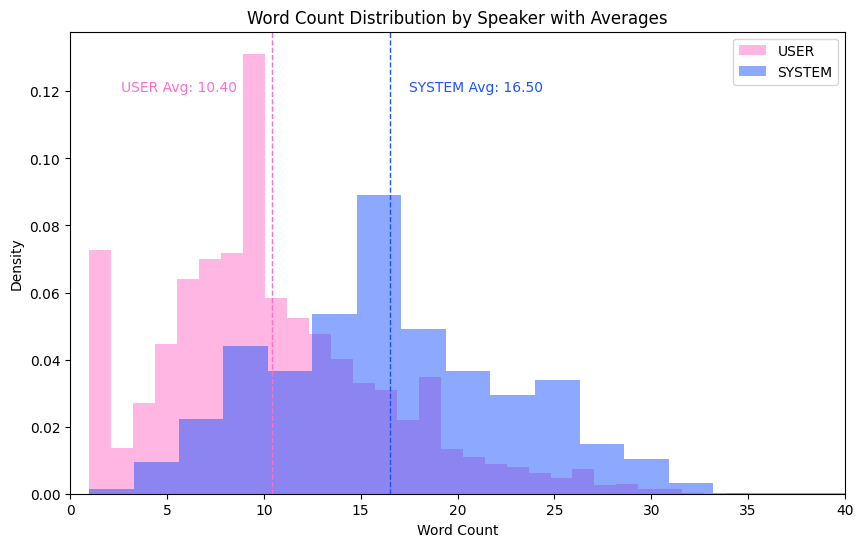

In [113]:
#VIZ distribution of word count, slice by user vs system

# mwoz = pd.read_csv('../data/output/mwoz_1processed.csv')
# Define custom colors for User and System
user_color = "#FF6EC7"  # Pink (Valence theme)
system_color = "#1A53FF"  # Blue (Valence theme)

# Filter data by speaker
user_word_counts = USER["word_count"]
system_word_counts = SYSTEM["word_count"]

# Calculate averages for User and System
user_avg = user_word_counts.mean()
system_avg = system_word_counts.mean()



# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(user_word_counts, bins=30, alpha=0.5, label="USER", density=True, color=user_color)
plt.hist(system_word_counts, bins=30, alpha=0.5, label="SYSTEM", density=True, color=system_color)

# Add average lines
plt.axvline(user_avg, color=user_color, linestyle="dashed", linewidth=1)
plt.axvline(system_avg, color=system_color, linestyle="dashed", linewidth=1)

# Add labels to the average lines
plt.text(user_avg - 1.8, 0.12, f"USER Avg: {user_avg:.2f}", color=user_color, fontsize=10, ha="right")
plt.text(system_avg + 1, 0.12, f"SYSTEM Avg: {system_avg:.2f}", color=system_color, fontsize=10, ha="left")

# Add title, labels, and legend
plt.title("Word Count Distribution by Speaker with Averages")
plt.xlabel("Word Count")
plt.ylabel("Density")
plt.legend(["USER", "SYSTEM"])  # Only speakers in legend, no averages
plt.xlim(0, 40)  # Adjust the x-axis range for a shorter word count axis
# plt.show()


##### Convo Level Viz

In [33]:
mwoz.head()

,index,Speaker,Text,Domain-Intent,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Domain,Intent,avg_rating,ConvID,turn_id,WordCount,wt_avg_rating,word_count
0,0,USER,I'm looking for a cheap restaurant in the east...,Restaurant-Inform,3.0,3.0,3.0,3.0,NaN,Restaurant,Inform,3.0,0,0,12,3.0,12
1,1,SYSTEM,the missing sock is a nice restaurant in the e...,Restaurant-Inform,NaN,NaN,NaN,NaN,NaN,Restaurant,Inform,NaN,0,1,18,NaN,18
2,2,USER,What is the address and phone number?,Restaurant-Request,3.0,3.0,3.0,3.0,NaN,Restaurant,Request,3.0,0,2,7,3.0,7
3,3,SYSTEM,The address of The Missing Sock is Finders Cor...,general-reqmore,NaN,NaN,NaN,NaN,NaN,general,reqmore,NaN,0,3,26,NaN,26
4,4,USER,Does this restaurant have highchairs for babies?,NaN,3.0,3.0,3.0,3.0,NaN,NaN,NaN,3.0,0,4,7,3.0,7


In [38]:
mwoz[(mwoz['Speaker']=='SYSTEM') &(mwoz['wt_avg_rating'].notna())]

,index,Speaker,Text,Domain-Intent,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Domain,Intent,avg_rating,ConvID,turn_id,WordCount,wt_avg_rating,word_count


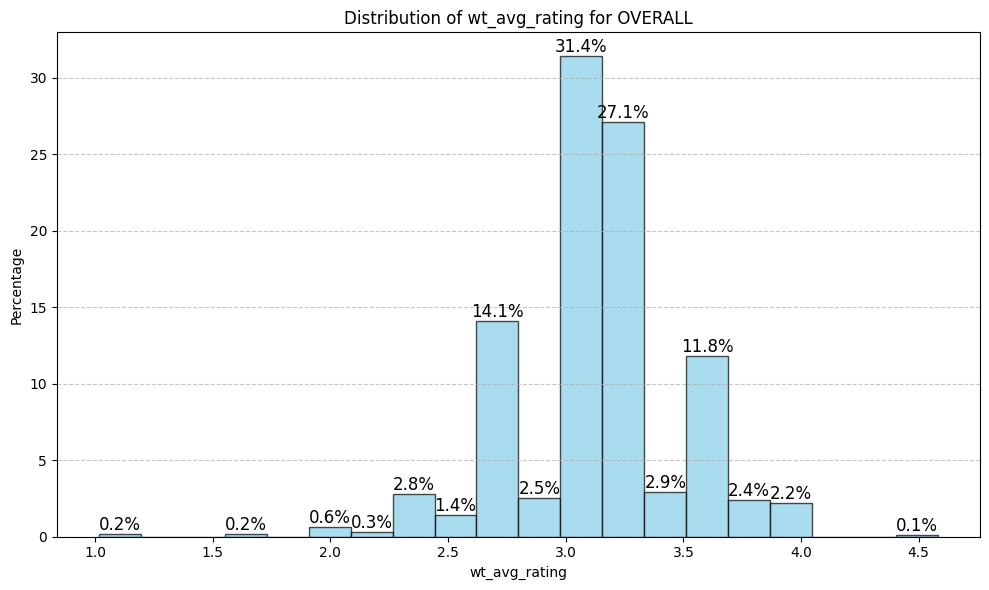

In [40]:
# Filter rows where the 'text' column contains "OVERALL"

import pandas as pd
import matplotlib.pyplot as plt

# data = mwoz

# Filter rows where the 'text' column contains "OVERALL"
# overall_rows = data[data["text"].str.contains("OVERALL", na=False)]
interest_rows = OVERALL
# Prepare the data
wt_avg_ratings = interest_rows["wt_avg_rating"].dropna()
# Calculate weights for percentages
weights = [100 / len(wt_avg_ratings)] * len(wt_avg_ratings)  # Normalize to percentages


# Plot the histogram
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(
    wt_avg_ratings,
    bins=20,
    weights=weights,  # Use weights to normalize to percentages
    color="skyblue",
    edgecolor="black",
    alpha=0.7
)

# Add annotations (% above each bar)
for i, count in enumerate(counts):
    if count > 0:  # Avoid adding annotations for empty bins
        percentage = f"{count:.1f}%"  
        plt.text((bins[i] + bins[i + 1]) / 2, count, percentage, ha='center', va='bottom', fontsize=12)

# Add titles and labels
plt.title("Distribution of wt_avg_rating for OVERALL")
plt.xlabel("wt_avg_rating")
plt.ylabel("Percentage")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



#### Add more features before sampling

In [92]:
#Add more features before sampling
mwoz['WordCount'] = mwoz['Text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)


In [93]:
#Store final cleaned subset for future work
mwoz.to_csv("data/mwoz_processed.csv", index=False)

### Sampling Conversations: Strat by Domain, WordCount, etc.

['Jury', "Atlanta's", 'irregularities', 'term-end', 'presentments', 'Executive', 'September-October', 'Durwood', 'Pye', 'hard-fought', 'Mayor-nominate', 'Ivan', "Georgia's", 'outmoded', 'modernizing', 'inure', 'Merger', 'Purchasing', 'clerical', 'Implementation']


In [42]:
#HELPER: sample 1 convo ID, return all associated rows
def sample_1(dataframe):
    """
    Randomly sample a single Conversation ID and return all rows associated with it, as df.
    """
    # Sample a single ConversationID
    sampled_conv_id = dataframe['ConvID'].sample(1).iloc[0]
    
    # Filter and return all rows for the sampled ConversationID
    return dataframe[dataframe['ConvID'] == sampled_conv_id]


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split

def stratified_train_test_split(data, conv_id_col='conv_ID', train_frac=0.8, random_state=42):
    """
    Splits a dataset into stratified train and test sets based on conversation IDs (conv_ID),
    and outputs them as CSV files.
    
    Args:
        data (pd.DataFrame): The full dataset.
        conv_id_col (str): The column name representing conversation IDs.
        train_frac (float): Proportion of conversations to include in the training set.
        random_state (int): Random seed for reproducibility.

    Returns:
        None
    """
    # Extract unique conversation IDs
    unique_conv_ids = data[conv_id_col].unique()
    
    # Perform train-test split on the conversation IDs
    train_ids, test_ids = train_test_split(
        unique_conv_ids, 
        train_size=train_frac, 
        random_state=random_state
    )
    
    # Split the data based on the conversation IDs
    train_data = data[data[conv_id_col].isin(train_ids)]
    test_data = data[data[conv_id_col].isin(test_ids)]
    
    # Save train and test datasets as CSV files
    train_file_path = "../data/output/train.csv"
    test_file_path = "../data/output/test.csv"
    
    train_data.to_csv(train_file_path, index=False)
    test_data.to_csv(test_file_path, index=False)
    
    print(f"Train set saved to {train_file_path} with {len(train_data)} rows and {train_data[conv_id_col].nunique()} unique conversations.")
    print(f"Test set saved to {test_file_path} with {len(test_data)} rows and {test_data[conv_id_col].nunique()} unique conversations.")

# Example usage
# Load your dataset
file_path = "../data/output/mwoz_1processed.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)

# Perform stratified split and save outputs
stratified_train_test_split(data, conv_id_col='conv_ID')


Train set saved to ../data/output/train.csv with 18532 rows and 800 unique conversations.
Test set saved to ../data/output/test.csv with 4576 rows and 200 unique conversations.
